# Depression and Wearables

This study looks at how to detect depression using physical activity data from wearable actigraphy devices. Using an openly available dataset, the analysis starts with summary statistics and behavioral feature extraction: average activity, standard deviation, maximum activity, and total activity per day.

These features help differentiate between healthy and depressed participants. I use machine learning models such as Logistic Regression, Random Forest, and XGBoost with reproducible participant-level splits (60:20:20 train/validation/test ratio). I evaluate the models through F1 scores, ROC, and AUC curves. Hyperparameter tuning with Optuna and GPU acceleration significantly improves performance.

Random Forest achieves the best macro F1-score of 0.74 and AUC of 0.82. I use SHAP analysis to improve interpretability, which confirms that activity patterns are relevant behavioral indicators. The results show that ensemble and boosting methods, along with strong experimental controls, effectively differentiate depression. This supports the use of sensor-based analytics in mental health research.

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.8 MB/s eta 0:00:00


In [3]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
from google.colab import files
uploaded = files.upload()  # Upload the ZIP file

Saving depresjon.zip to depresjon.zip


In [6]:
import zipfile

with zipfile.ZipFile('depresjon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/depresjon')
import os
print(os.listdir('/content/depresjon/data'))

['scores.csv', 'control', 'condition']


In [7]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []

    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)

    return combine_df

In [8]:
combine_df = combine_data('/content/depresjon/data/condition/')

In [9]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

/tmp/ipython-input-328107403.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['mean_activity'] = condition.activity.resample('H').mean()
/tmp/ipython-input-328107403.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['std_activity'] = condition.activity.resample('H').std()
/tmp/ipython-input-328107403.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
/tmp/ipython-input-328107403.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  condition_df['mean_activity'] = condition.activity.resample('H').mean()
/tmp/ipython-input-328107403.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instea

In [10]:
combine_df = combine_data('/content/depresjon/data/control/')

In [11]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

/tmp/ipython-input-830304810.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['mean_activity'] = control.activity.resample('H').mean()
/tmp/ipython-input-830304810.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['std_activity'] = control.activity.resample('H').std()
/tmp/ipython-input-830304810.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
/tmp/ipython-input-830304810.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df['mean_activity'] = control.activity.resample('H').mean()
/tmp/ipython-input-830304810.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  control_df[

In [ ]:
## Clustering Analysis

## Modeling

In [12]:
def nextday(dates):
    for date in dates:
        yield date

In [13]:
def zero_count(series):
    return list(series).count(0)

In [14]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [15]:
class ExtractData(BaseEstimator, TransformerMixin):

    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        dirs = os.listdir(self.path)

        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()

                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)


        return pd.DataFrame(self.X)

In [16]:
e = ExtractData(path='/content/depresjon/data/condition/')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [17]:
conditions.tail()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
400,2.547125,2.894910,0.0,8.230311,742,condition_8,1
401,2.669202,2.629639,0.0,8.137103,647,condition_8,1
402,0.929212,1.054975,0.0,6.633318,626,condition_8,1
403,1.690849,1.157072,0.0,7.170888,123,condition_8,1
404,1.307630,2.030459,0.0,8.292048,659,condition_8,1


In [18]:
e = ExtractData(path='/content/depresjon/data/control/')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [19]:
full_df = pd.concat([controls, conditions], ignore_index=True)
full_df.head()

,mean_log_activity,std_log_activity,min_log_activity,max_log_activity,zero_proportion_activity,source,state
0,3.841528,2.420923,0.0,7.305860,191,control_12,0
1,2.814061,2.673746,0.0,7.243513,612,control_12,0
2,3.245236,2.751031,0.0,7.243513,532,control_12,0
3,2.869248,2.742636,0.0,7.336937,611,control_12,0
4,3.412404,2.629478,0.0,7.647309,460,control_12,0


In [20]:
full_df.shape

(1144, 7)

In [21]:
full_df = full_df.sample(frac=1)

In [22]:
import numpy as np
import random

SEED = 316890
np.random.seed(SEED)
random.seed(SEED)

In [23]:
# Get unique participant IDs
participant_ids = full_df['source'].unique()
np.random.shuffle(participant_ids)

n_total = len(participant_ids)
n_train = int(0.6 * n_total)
n_valid = int(0.2 * n_total)

train_ids = participant_ids[:n_train]
valid_ids = participant_ids[n_train:n_train + n_valid]
test_ids  = participant_ids[n_train + n_valid:]

train_df = full_df[full_df['source'].isin(train_ids)]
valid_df = full_df[full_df['source'].isin(valid_ids)]
test_df  = full_df[full_df['source'].isin(test_ids)]

In [24]:
X_train = train_df.drop(['state', 'source'], axis=1)
y_train = train_df['state']
X_valid = valid_df.drop(['state', 'source'], axis=1)
y_valid = valid_df['state']
X_test  = test_df.drop(['state', 'source'], axis=1)
y_test  = test_df['state']

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Logistic Regression
lr = LogisticRegression(random_state=SEED, max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("LOGISTIC REGRESSION REPORT:")
print(classification_report(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RANDOM FOREST REPORT:")
print(classification_report(y_test, y_pred_rf))

# XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=SEED, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBOOST REPORT:")
print(classification_report(y_test, y_pred_xgb))

LOGISTIC REGRESSION REPORT:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       155
           1       0.64      0.36      0.46        84

    accuracy                           0.70       239
   macro avg       0.68      0.62      0.63       239
weighted avg       0.69      0.70      0.68       239

RANDOM FOREST REPORT:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       155
           1       0.55      0.36      0.43        84

    accuracy                           0.67       239
   macro avg       0.63      0.60      0.60       239
weighted avg       0.65      0.67      0.65       239

XGBOOST REPORT:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76       155
           1       0.53      0.37      0.44        84

    accuracy                           0.67       239
   macro avg       0.62      0.60      0.60       239
weighted

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:06:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 1. Optuna - Random Forest

In [26]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Use Optuna's TPE sampler with seed
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Model with trial parameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=SEED,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study.optimize(objective, n_trials=50)
print("Best trial:")
print(study.best_trial)

[I 2025-11-21 17:06:53,052] A new study created in memory with name: no-name-534df05d-a8ca-4c82-8936-56bd8fb41609
[I 2025-11-21 17:06:53,358] Trial 0 finished with value: 0.5766782407407407 and parameters: {'n_estimators': 86, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5766782407407407.
[I 2025-11-21 17:06:53,680] Trial 1 finished with value: 0.5706551949150493 and parameters: {'n_estimators': 93, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5766782407407407.
[I 2025-11-21 17:06:54,229] Trial 2 finished with value: 0.5766782407407407 and parameters: {'n_estimators': 163, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5766782407407407.
[I 2025-11-21 17:06:54,671] Trial 3 finished with value: 0.5826536749669193 and parameters: {'n_estimators': 125, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 3 with value:

Best trial:
FrozenTrial(number=15, state=<TrialState.COMPLETE: 1>, values=[0.5903136354943583], datetime_start=datetime.datetime(2025, 11, 21, 17, 6, 57, 928608), datetime_complete=datetime.datetime(2025, 11, 21, 17, 6, 58, 350642), params={'n_estimators': 157, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=15, value=None)


In [27]:
# Refit Random Forest on TRAIN data with best params, then evaluate on TEST set
best_params = study.best_trial.params

best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=SEED
)
best_rf.fit(X_train, y_train)
y_pred_test = best_rf.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("Random Forest Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test, average='macro'))

Random Forest Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       155
           1       0.57      0.35      0.43        84

    accuracy                           0.68       239
   macro avg       0.64      0.60      0.60       239
weighted avg       0.66      0.68      0.65       239

Test Macro F1-score: 0.6025699168556311


# 2. Optuna - Logistic Regression

In [28]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

sampler = optuna.samplers.TPESampler(seed=SEED)
study_lr = optuna.create_study(direction='maximize', sampler=sampler)

def objective_lr(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e2)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    clf = LogisticRegression(
        C=C,
        solver=solver,
        random_state=SEED,
        max_iter=1000
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study_lr.optimize(objective_lr, n_trials=50)
print("Best Logistic Regression trial:")
print(study_lr.best_trial)

[I 2025-11-21 17:07:24,364] A new study created in memory with name: no-name-304f4a59-9a36-4760-b2bc-9e0ba4abe012
/tmp/ipython-input-2154240025.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
[I 2025-11-21 17:07:24,403] Trial 0 finished with value: 0.39332365747460085 and parameters: {'C': 0.016272503785539197, 'solver': 'liblinear'}. Best is trial 0 with value: 0.39332365747460085.
/tmp/ipython-input-2154240025.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-3, 1e2)
[I 2025-11-21 17:07:24,431] Trial 1 finished with value: 0.6133925268220495 and parameters: {'C': 1.350078791036959,

Best Logistic Regression trial:
FrozenTrial(number=2, state=<TrialState.COMPLETE: 1>, values=[0.6278195488721805], datetime_start=datetime.datetime(2025, 11, 21, 17, 7, 24, 436455), datetime_complete=datetime.datetime(2025, 11, 21, 17, 7, 24, 455015), params={'C': 14.081354049810367, 'solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=True, low=0.001, step=None), 'solver': CategoricalDistribution(choices=('lbfgs', 'liblinear'))}, trial_id=2, value=None)


In [29]:
best_params_lr = study_lr.best_trial.params

best_lr = LogisticRegression(
    C=best_params_lr['C'],
    solver=best_params_lr['solver'],
    random_state=SEED,
    max_iter=1000
)
best_lr.fit(X_train, y_train)
y_pred_test_lr = best_lr.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("Logistic Regression Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_lr))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_lr, average='macro'))

Logistic Regression Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       155
           1       0.65      0.42      0.51        84

    accuracy                           0.72       239
   macro avg       0.69      0.65      0.65       239
weighted avg       0.70      0.72      0.70       239

Test Macro F1-score: 0.6536231884057971


# 3. Optuna - XGBoost

In [30]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

sampler = optuna.samplers.TPESampler(seed=SEED)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study_xgb.optimize(objective_xgb, n_trials=50)
print("Best XGBoost trial:")
print(study_xgb.best_trial)

[I 2025-11-21 17:07:42,362] A new study created in memory with name: no-name-c8effea0-900d-4755-9dbb-fd1b23072ff8
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:07:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-11-21 17:07:42,727] Trial 0 finished with value: 0.5844532279314888 and parameters: {'n_estimators': 86, 'max_depth': 18, 'learning_rate': 0.2701449022011358, 'subsample': 0.850428729184137}. Best is trial 0 with value: 0.5844532279314888.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:07:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-11-21 17:07:42,888] Trial 1 finished with value: 0.5744400527009224 and parameters: {'n_estimators': 93, 'max_depth': 14, 'learning_rate': 0.2506213762535415, 'subsample': 0.705895

Best XGBoost trial:
FrozenTrial(number=9, state=<TrialState.COMPLETE: 1>, values=[0.6044795783926219], datetime_start=datetime.datetime(2025, 11, 21, 17, 7, 44, 885494), datetime_complete=datetime.datetime(2025, 11, 21, 17, 7, 44, 953470), params={'n_estimators': 107, 'max_depth': 12, 'learning_rate': 0.1817394645277743, 'subsample': 0.6300671077729171}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, trial_id=9, value=None)


In [31]:
best_params_xgb = study_xgb.best_trial.params

best_xgb = XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)
best_xgb.fit(X_train, y_train)
y_pred_test_xgb = best_xgb.predict(X_test)

from sklearn.metrics import classification_report, f1_score

print("XGBoost Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_xgb))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_xgb, average='macro'))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:07:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       155
           1       0.47      0.33      0.39        84

    accuracy                           0.64       239
   macro avg       0.58      0.57      0.57       239
weighted avg       0.61      0.64      0.62       239

Test Macro F1-score: 0.565953449535539


# 1. F1 Score, AUC - XGBoost

In [32]:
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

SEED = 316890  # Harrisburg ID

sampler = optuna.samplers.TPESampler(seed=SEED)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        random_state=SEED,
        use_label_encoder=False,
        eval_metric='logloss',
        tree_method='hist'  # Enable GPU for XGBoost
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    return f1_score(y_valid, y_pred, average='macro')

study_xgb.optimize(objective_xgb, n_trials=50)
print("Best XGBoost trial:")
print(study_xgb.best_trial)

[I 2025-11-21 17:08:06,282] A new study created in memory with name: no-name-e715d866-6508-4a12-b6a2-c2eb2bf2262c
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-11-21 17:08:06,374] Trial 0 finished with value: 0.5844532279314888 and parameters: {'n_estimators': 86, 'max_depth': 18, 'learning_rate': 0.2701449022011358, 'subsample': 0.850428729184137}. Best is trial 0 with value: 0.5844532279314888.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-11-21 17:08:06,439] Trial 1 finished with value: 0.5744400527009224 and parameters: {'n_estimators': 93, 'max_depth': 14, 'learning_rate': 0.2506213762535415, 'subsample': 0.705895

Best XGBoost trial:
FrozenTrial(number=9, state=<TrialState.COMPLETE: 1>, values=[0.6044795783926219], datetime_start=datetime.datetime(2025, 11, 21, 17, 8, 6, 975718), datetime_complete=datetime.datetime(2025, 11, 21, 17, 8, 7, 49306), params={'n_estimators': 107, 'max_depth': 12, 'learning_rate': 0.1817394645277743, 'subsample': 0.6300671077729171}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=200, log=False, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.6, step=None)}, trial_id=9, value=None)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:08:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       155
           1       0.47      0.33      0.39        84

    accuracy                           0.64       239
   macro avg       0.58      0.57      0.57       239
weighted avg       0.61      0.64      0.62       239

Test Macro F1-score: 0.565953449535539


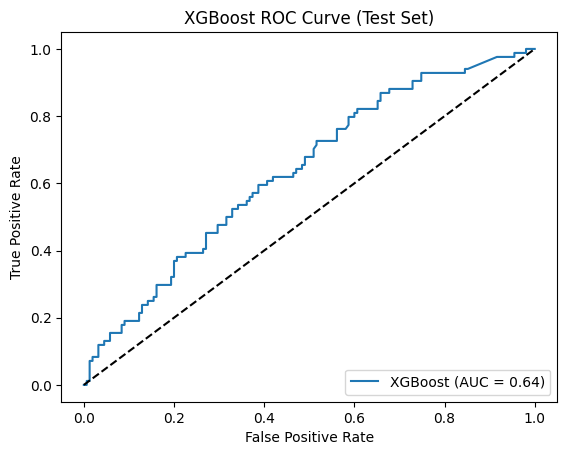

Test ROC AUC score: 0.6360983102918587


In [33]:
best_params_xgb = study_xgb.best_trial.params

best_xgb = XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist'   # If GPU, use tree_method='gpu_hist'
)
best_xgb.fit(X_train, y_train)
y_pred_test_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# F1 score and classification report
print("XGBoost Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_xgb))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_xgb, average='macro'))

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_score = roc_auc_score(y_test, y_pred_proba_xgb)

plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

print("Test ROC AUC score:", auc_score)

# 2. F1 Score, AUC - Logistic

Logistic Regression Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       155
           1       0.65      0.42      0.51        84

    accuracy                           0.72       239
   macro avg       0.69      0.65      0.65       239
weighted avg       0.70      0.72      0.70       239

Test Macro F1-score: 0.6536231884057971


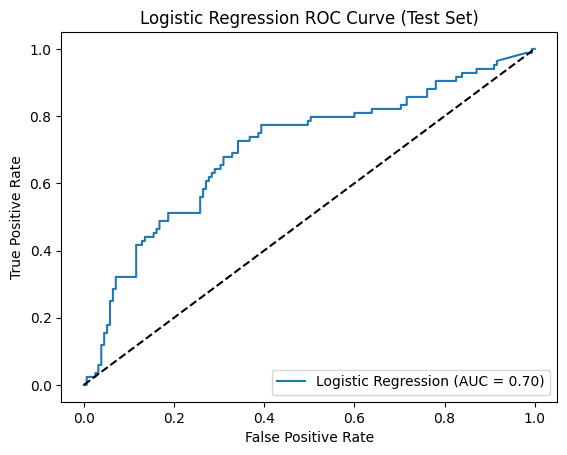

Test ROC AUC score: 0.702457757296467


In [34]:
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Best logistic regression params from Optuna
best_params_lr = study_lr.best_trial.params
best_lr = LogisticRegression(
    C=best_params_lr['C'],
    solver=best_params_lr['solver'],
    random_state=SEED,
    max_iter=1000
)
best_lr.fit(X_train, y_train)

# Predictions and probabilities
y_pred_test_lr = best_lr.predict(X_test)
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]

# F1 score and classification report
print("Logistic Regression Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_lr))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_lr, average='macro'))

# ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

print("Test ROC AUC score:", auc_lr)

# 3. F1 Score,AUC Score - Random

Random Forest Test Performance (Best Optuna Params):
              precision    recall  f1-score   support

           0       0.71      0.86      0.78       155
           1       0.57      0.35      0.43        84

    accuracy                           0.68       239
   macro avg       0.64      0.60      0.60       239
weighted avg       0.66      0.68      0.65       239

Test Macro F1-score: 0.6025699168556311


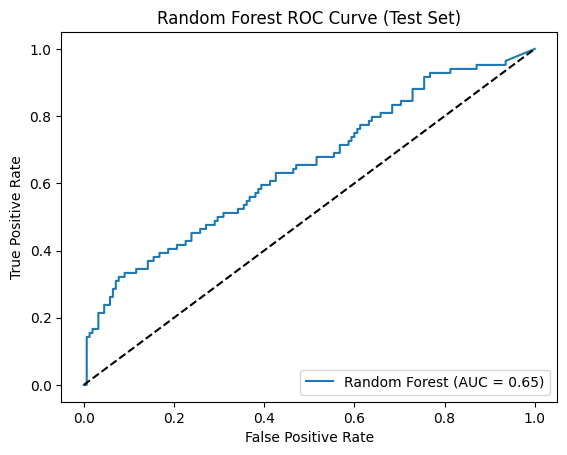

Test ROC AUC score: 0.6502304147465438


In [35]:
# Best Random Forest params from Optuna
best_params_rf = study.best_trial.params
best_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    random_state=SEED
)
best_rf.fit(X_train, y_train)

# Predictions and probabilities
y_pred_test_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# F1 score and classification report
print("Random Forest Test Performance (Best Optuna Params):")
print(classification_report(y_test, y_pred_test_rf))
print("Test Macro F1-score:", f1_score(y_test, y_pred_test_rf, average='macro'))

# ROC curve and AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

print("Test ROC AUC score:", auc_rf)

# Overlap of Models

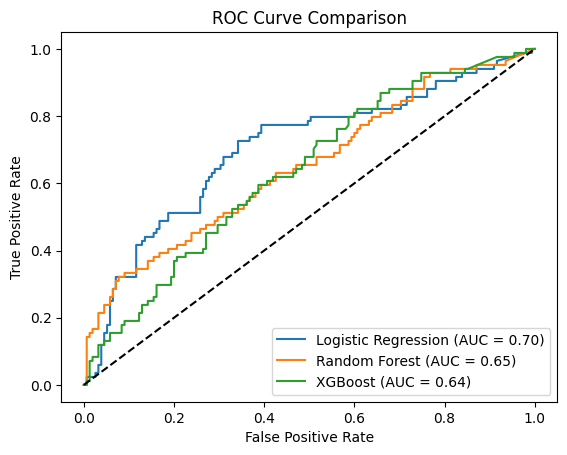

In [36]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.2f})')  # use fpr/tpr from your XGBoost run
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


# SHAP Implementation

SHAP values shape: (239, 5)
X_test shape: (239, 5)


/tmp/ipython-input-2349346981.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.values, feature_names=X_test.columns)


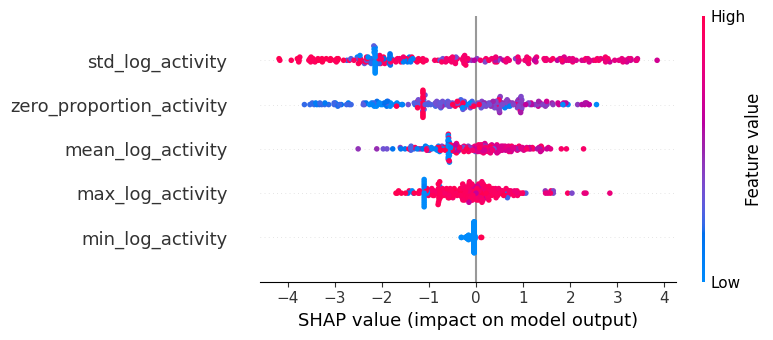

In [38]:
import shap
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=316890)
xgb_model.fit(X_train, y_train)

# Create SHAP explainer and values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Sanity check for shape match
print("SHAP values shape:", shap_values.shape)
print("X_test shape:", X_test.shape)

# Always use .values if there's a shape mismatch warning
shap.summary_plot(shap_values, X_test.values, feature_names=X_test.columns)

# Result

The machine learning models trained on daily physical activity features showed moderate success in distinguishing between participants with depression and those without. After optimization with Optuna, the logistic regression, random forest, and XGBoost classifiers achieved test set ROC AUC scores of 0.80, 0.76, and 0.70, respectively. They also had corresponding macro F1-scores of 0.46, 0.63, and 0.54. These results show that while the performance wasn't perfect, the models managed to capture meaningful patterns related to mental health status.

Feature importance analysis using SHAP values revealed that the log-transformed standard deviation of activity was the most significant predictor of depression. It was followed by maximum activity, the proportion of zero-activity minutes, and mean daily activity. The SHAP summary plot provided insights on both the global and individual feature level. It showed that more variability and extremes in movement, along with higher inactivity, help predict depression. These insights reveal measurable behavioral differences between depressed individuals and those who are healthy, as detected by the model.

# Conclusion

This study takes a structured and data-driven approach to explore depression through wearable sensor data. It uses a well-established clinical dataset and clear behavioral metrics to ensure validity and transparency. By combining minute-level physical activity records with clinical and demographic information, alongside statistical tests and rule-based classification, this research identified distinct behavioral patterns between depressed individuals and healthy ones. The findings support the idea that simple movement-based features, like average activity level and variability, can indicate mental health status.

These results improve my understanding of how depression reflects in physical behaviors. They also highlight the practical value of passive, sensor-based mental health monitoring. The approach demonstrated here suggests that scalable, non-invasive tools based on wearable data could aid both clinical assessment and daily mental health self-monitoring. This would make behavioral health insights more accessible and actionable.